In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense


In [ ]:
data = pd.read_csv('dataset.csv')

print(data.head(5))

   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200           None  
1         125/80          75      

In [ ]:
data.isnull().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

In [ ]:
print(data.describe())

        Person ID         Age  Sleep Duration  Quality of Sleep  \
count  374.000000  374.000000      374.000000        374.000000   
mean   187.500000   42.184492        7.132086          7.312834   
std    108.108742    8.673133        0.795657          1.196956   
min      1.000000   27.000000        5.800000          4.000000   
25%     94.250000   35.250000        6.400000          6.000000   
50%    187.500000   43.000000        7.200000          7.000000   
75%    280.750000   50.000000        7.800000          8.000000   
max    374.000000   59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level  Heart Rate   Daily Steps  
count               374.000000    374.000000  374.000000    374.000000  
mean                 59.171123      5.385027   70.165775   6816.844920  
std                  20.830804      1.774526    4.135676   1617.915679  
min                  30.000000      3.000000   65.000000   3000.000000  
25%                  45.000000 

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None


In [ ]:
# Hitung batas bawah dan atas untuk setiap fitur
col = ['Heart Rate', 'Age', 'Daily Steps', 'Physical Activity Level','Sleep Disorder']
Q1 = data[col].quantile(0.25)
Q3 = data[col].quantile(0.75)

# Hitung IQR (Interquartile Range)
IQR = Q3 - Q1

threshold = 3
# Tentukan batas bawah dan atas untuk setiap fitur
lower_bound = data[col].quantile(0.25) - (IQR * threshold)
upper_bound = data[col].quantile(0.75) + (IQR * threshold)

# Lakukan Winsorization pada setiap fitur
for column in data[['Heart Rate', 'Age', 'Daily Steps', 'Physical Activity Level']]:
    data[column] = np.where(data[column] < lower_bound[column], lower_bound[column], data[column])
    data[column] = np.where(data[column] > upper_bound[column], upper_bound[column], data[column])

In [ ]:
# Label Encoding untuk variabel kategorikal
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['BMI Category'] = label_encoder.fit_transform(data['BMI Category'])
data['Blood Pressure'] = label_encoder.fit_transform(data['Blood Pressure'])
data['Occupation'] = label_encoder.fit_transform(data['Occupation'])


# One-hot encoding untuk variabel target "Sleep Disorder"
data = pd.get_dummies(data, columns=['Sleep Disorder'], drop_first=True)

<AxesSubplot:xlabel='Quality of Sleep', ylabel='Count'>

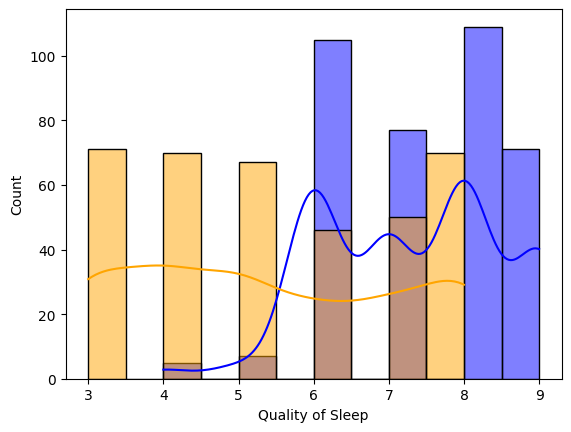

In [ ]:
sns.histplot(data["Quality of Sleep"], kde=True, color="blue")
sns.histplot(data["Stress Level"], kde=True, color="orange")

<AxesSubplot:xlabel='Quality of Sleep', ylabel='Stress Level'>

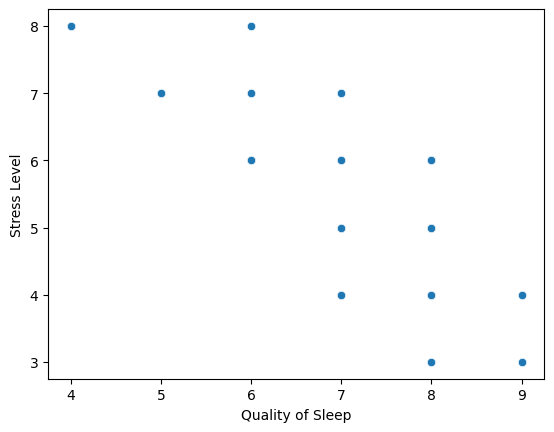

In [ ]:
sns.scatterplot(x="Quality of Sleep", y="Stress Level", data=data)

<AxesSubplot:xlabel='Age', ylabel='Quality of Sleep'>

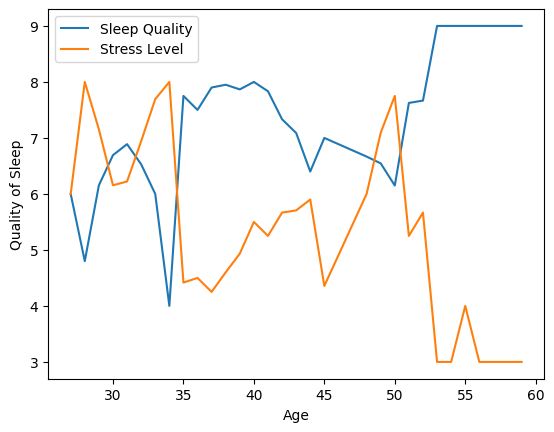

In [ ]:
grouped = data.groupby("Age").agg({"Quality of Sleep": "mean", "Stress Level": "mean"})
sns.lineplot(x="Age", y="Quality of Sleep", data=grouped, label="Sleep Quality")
sns.lineplot(x="Age", y="Stress Level", data=grouped, label="Stress Level")

<AxesSubplot:xlabel='Physical Activity Level', ylabel='Quality of Sleep'>

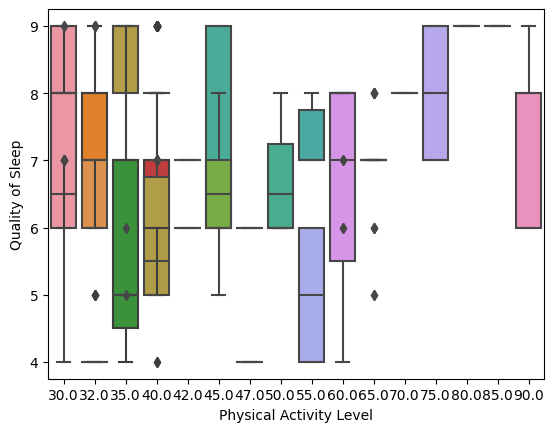

In [ ]:
sns.boxplot(x="BMI Category", y="Quality of Sleep", data=data)
sns.boxplot(x="Occupation", y="Quality of Sleep", data=data)
sns.boxplot(x="Physical Activity Level", y="Quality of Sleep", data=data)

<AxesSubplot:>

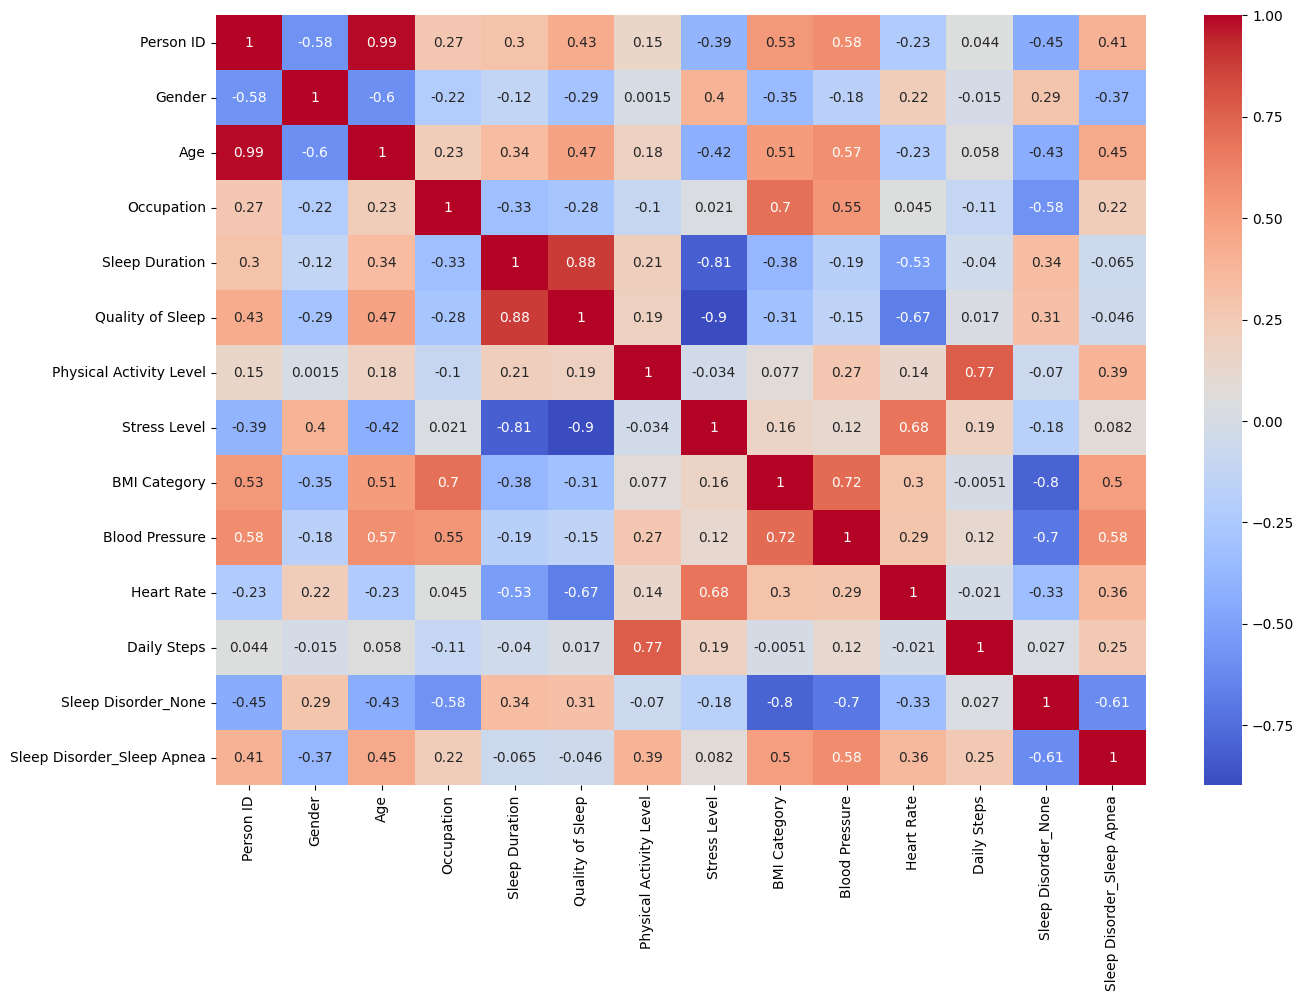

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", ax = ax)

Data: 1    219
0    155
Name: Sleep Disorder_None, dtype: int64


<AxesSubplot:>

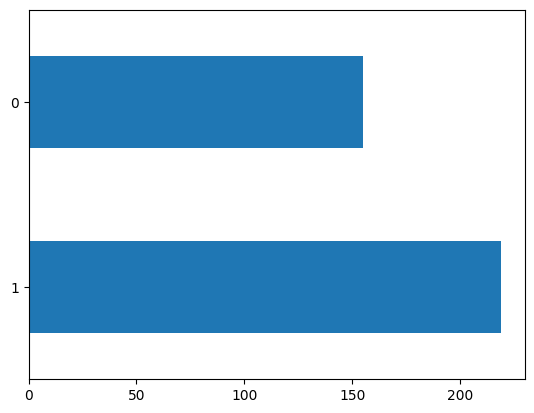

In [ ]:
print(f"Data: {data['Sleep Disorder_None'].value_counts()}")
data['Sleep Disorder_None'].value_counts().plot(kind='barh')

In [ ]:
# Melakukan scaling pada fitur-fitur
sc = StandardScaler()
X = data.drop(['Sleep Disorder_Sleep Apnea', 'Sleep Disorder_None'], axis=1)
y = data['Sleep Disorder_Sleep Apnea']  # Memilih salah satu kolom target, karena keduanya merepresentasikan target yang sama
X_scaled = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
from keras.regularizers import l1_l2

# Membangun model Sequential ANN dengan regularisasi L1/L2
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(l1=0.03, l2=0.03))) # layer input dengan regularisasi L1/L2
model.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.03, l2=0.03))) # hidden layer dengan regularisasi L1/L2
model.add(Dense(1, activation='sigmoid')) # layer output

# Kompilasi model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall','MSE'])

# Melatih model menggunakan data latih
model.fit(X_train, y_train, epochs=75, batch_size=15)

# Evaluasi model pada data uji
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



Epoch 1/75
18/18 [==============================] - 1s 1ms/step - loss: 3.0851 - accuracy: 0.3372 - precision: 0.1325 - recall: 0.4314 - MSE: 0.2712
Epoch 2/75
18/18 [==============================] - 0s 1ms/step - loss: 2.8832 - accuracy: 0.3755 - precision: 0.1364 - recall: 0.4118 - MSE: 0.2470    
Epoch 3/75
18/18 [==============================] - 0s 1ms/step - loss: 2.6979 - accuracy: 0.5402 - precision: 0.1892 - recall: 0.4118 - MSE: 0.2275    
Epoch 4/75
18/18 [==============================] - 0s 1ms/step - loss: 2.5272 - accuracy: 0.7011 - precision: 0.2857 - recall: 0.3529 - MSE: 0.2113
Epoch 5/75
18/18 [==============================] - 0s 1ms/step - loss: 2.3662 - accuracy: 0.8161 - precision: 0.5789 - recall: 0.2157 - MSE: 0.1974
Epoch 6/75
18/18 [==============================] - 0s 1ms/step - loss: 2.2148 - accuracy: 0.8123 - precision: 1.0000 - recall: 0.0392 - MSE: 0.1849
Epoch 7/75
18/18 [==============================] - 0s 965us/step - loss: 2.0712 - accuracy: 0.812

4/4 [==============================] - 0s 1ms/step
Epoch 1/75
18/18 [==============================] - 0s 4ms/step - loss: 0.4046 - accuracy: 0.9080 - precision: 0.8462 - recall: 0.6471 - MSE: 0.0758 - val_loss: 0.4498 - val_accuracy: 0.8761 - val_precision: 0.9333 - val_recall: 0.5185 - val_MSE: 0.0950
Epoch 2/75
18/18 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8966 - precision: 0.8333 - recall: 0.5882 - MSE: 0.0756 - val_loss: 0.4491 - val_accuracy: 0.8761 - val_precision: 0.9333 - val_recall: 0.5185 - val_MSE: 0.0952
Epoch 3/75
18/18 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.8927 - precision: 0.8485 - recall: 0.5490 - MSE: 0.0752 - val_loss: 0.4474 - val_accuracy: 0.8584 - val_precision: 0.9231 - val_recall: 0.4444 - val_MSE: 0.0949
Epoch 4/75
18/18 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.9080 - precision: 0.8462 - recall: 0.6471 - MSE: 0.0748 - val_loss: 0.4456 - val_accuracy: 0.8

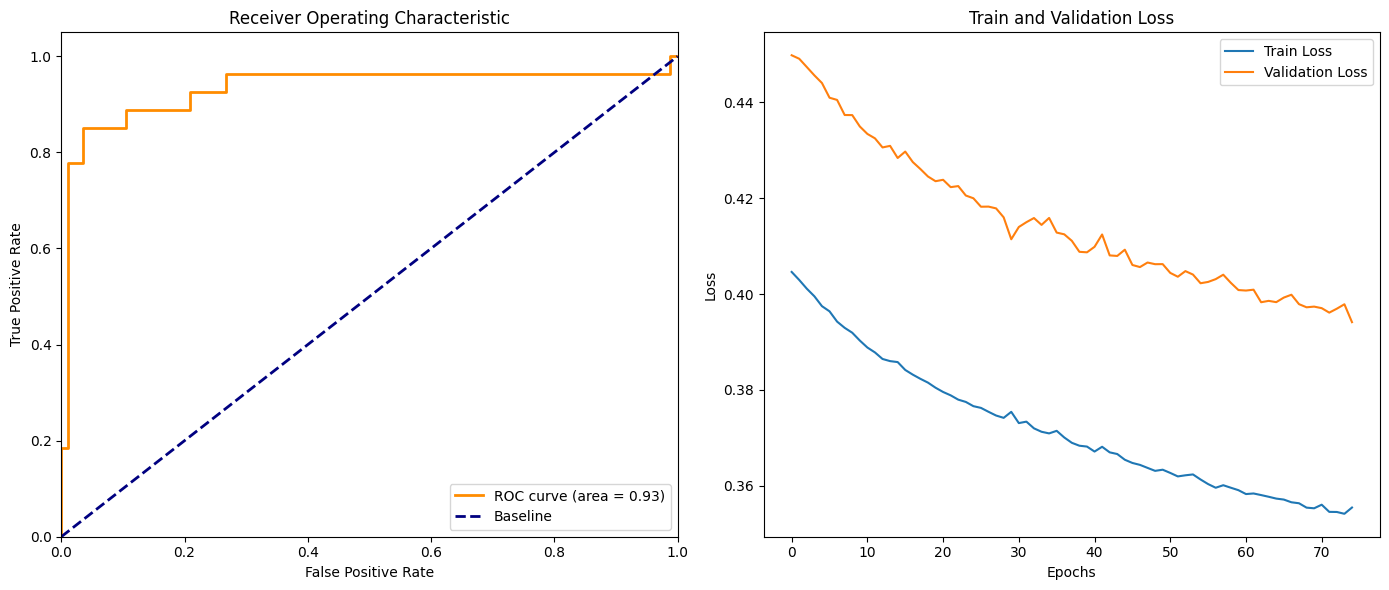

In [ ]:
# Prediksi probabilitas pada data uji
y_pred_prob = model.predict(X_test)

# Hitung ROC curve dan AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Melatih model menggunakan data latih dan simpan riwayat pelatihan
history = model.fit(X_train, y_train, epochs=75, batch_size=15, validation_data=(X_test, y_test))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Baseline")
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Loss vs Epochs
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Train and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


4/4 [==============================] - 0s 846us/step
Confusion Matrix:
[[85  1]
 [ 7 20]]


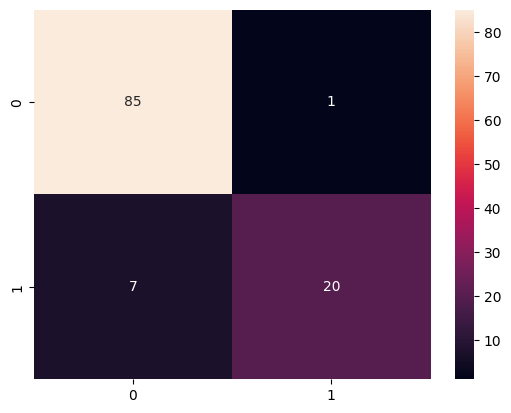

In [ ]:
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(confusion_matrix(y_test, y_pred_binary), annot=True,fmt='d')

# Output confusion matrix
print("Confusion Matrix:")
print(cm)